## Statsmodels

- statsmodels은 OLS를 비롯한 회귀분석과 통계적 해석에 필요한 도구를 제공해주는 library이다.
- 선형 회귀분석을 비롯해 시계열 모형, 칼만 필터 등 다양한 도구 사용이 가능하다.

In [1]:
# !pip install statsmodels

### Ordinary Least Squares (OLS)

OLS는 설명변수와 종속변수의 관계를 보기 위해 추정하는 모형이다. 변수는 서로 독립적인 iid 정규분포에서 샘플링 된 데이터를 사용해야 한다

In [1]:
import yfinance as yf
import pandas_datareader as web
import datetime

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2024, 2, 20)

kospi = web.DataReader("KOSPI", "naver", start_date, end_date)
snp = yf.download('^GSPC', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

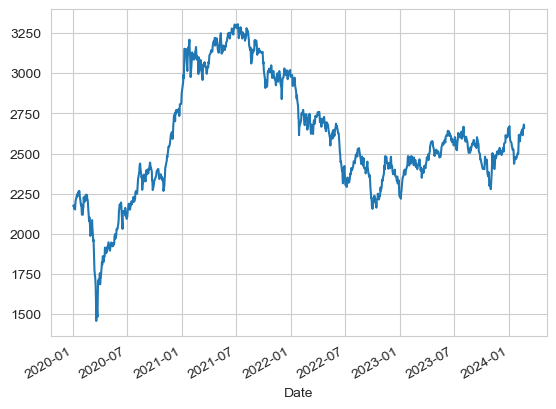

In [2]:
kospi.Close.astype(float).plot()

<Axes: xlabel='Date'>

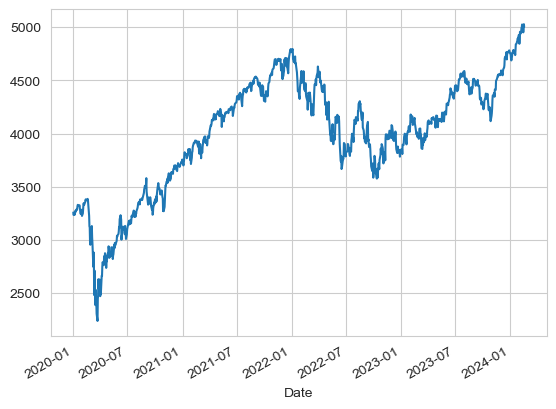

In [3]:
snp.Close.plot()

자산가격과 같은 시계열은 메모리가 포함되어 있기 때문에, 수익률 데이터로 변환해야 한다

In [4]:
kospi_ret = kospi.Close.astype(float).pct_change()
snp_ret = snp.Close.pct_change()

In [5]:
import pandas as pd
import numpy as np

ret_matrix = pd.concat([
    kospi_ret, snp_ret.shift(1) # 미국-한국 시차 고려
], axis = 1)
ret_matrix.dropna(inplace = True) # 각국 공휴일이 다르기 때문에 시간을 맞춰야 한다
ret_matrix.columns = ['KOSPI','S&P500']

In [6]:
ret_matrix

,KOSPI,S&P500
Date,,
2020-01-06,-0.009828,-0.007060
2020-01-07,0.009499,0.003533
2020-01-08,-0.011137,-0.002803
2020-01-09,0.016334,0.004902
2020-01-10,0.009120,0.006655
...,...,...
2024-02-08,0.004116,0.008241
2024-02-13,0.011189,-0.000949
2024-02-14,-0.011028,-0.013674


<Axes: xlabel='Date'>

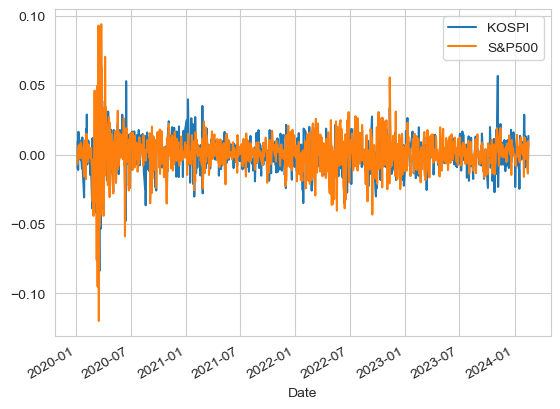

In [7]:
ret_matrix.plot()

`matplotlib`에서 `scatter()`을 사용하면 산점도를 찍을 수 있다

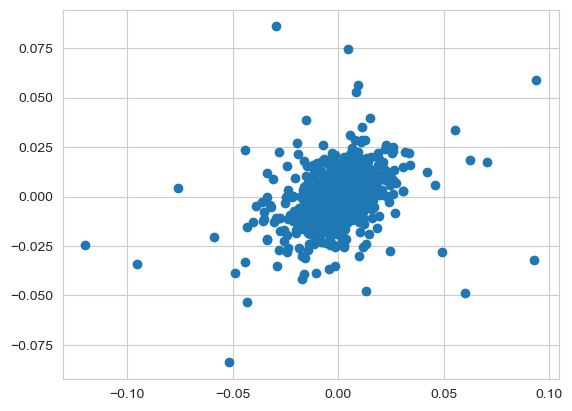

In [8]:
import matplotlib.pyplot as plt
plt.scatter(
    ret_matrix['S&P500'], ret_matrix['KOSPI']
)

argument에서 marker를 통해 모양을 바꿀 수 있다

Text(0, 0.5, 'KOSPI')

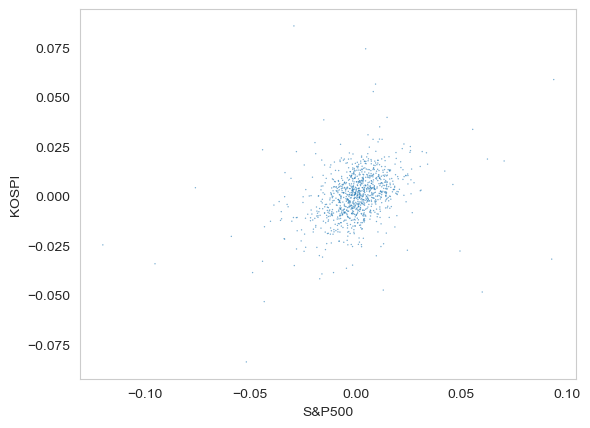

In [10]:
plt.scatter(
    ret_matrix['S&P500'], ret_matrix['KOSPI'],
    marker = '.',
    alpha = 0.6, # 투명도 조절
    edgecolor = 'none', # 테두리 삭제
    s = 4 # 산점 사이즈 조절
)
plt.grid()
plt.xlabel('S&P500')
plt.ylabel('KOSPI')

한국과 미국의 증권시장은 선형관계가 있는지 알아보기 위해 회귀분석을 진행한다

In [11]:
import statsmodels.api as sm

X = ret_matrix['S&P500'] # 설명변수 
X = sm.add_constant(X) # 상수항 추가
y = ret_matrix['KOSPI'] # 종속변수

In [12]:
X.head()

,const,S&P500
Date,,
2020-01-06,1.0,-0.007060
2020-01-07,1.0,0.003533
2020-01-08,1.0,-0.002803
2020-01-09,1.0,0.004902
2020-01-10,1.0,0.006655


In [13]:
y.head()

Date
2020-01-06   -0.009828
2020-01-07    0.009499
2020-01-08   -0.011137
2020-01-09    0.016334
2020-01-10    0.009120
Name: KOSPI, dtype: float64

`OLS()` 함수를 사용하면 선형 회귀모형을 생성할 수 있다

In [14]:
model = sm.OLS(y, X)

`fit()` method를 사용하여 회귀선을 추정할 수 있다

In [15]:
fit = model.fit()

`summary()` method를 사용하여 추정된 결과의 레포트를 받아볼 수 있다

In [16]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     131.6
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           1.10e-28
Time:                        22:16:27   Log-Likelihood:                 2949.1
No. Observations:                 984   AIC:                            -5894.
Df Residuals:                     982   BIC:                            -5884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.985e-05      0.000      0.259      0.7

`fittedvalues`를 통해 추정된 결과를 불러올 수 있다

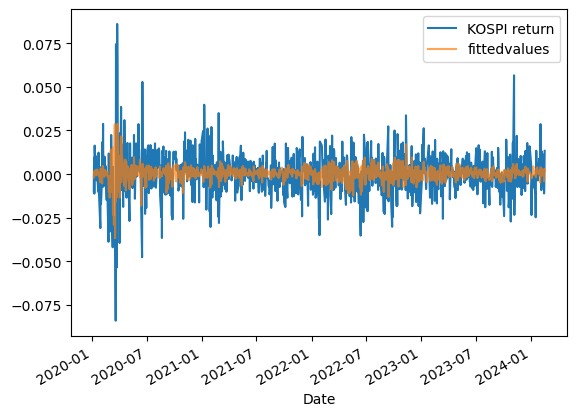

In [20]:
ret_matrix['KOSPI'].plot(label = 'KOSPI return')
fit.fittedvalues.plot(alpha = 0.7, label = 'fittedvalues')
plt.legend()
plt.show()

`params` attribute를 사용하면 추정된 베타를 볼 수 있다

In [17]:
fit.params

const     0.00010
S&P500    0.30645
dtype: float64

#### Multiple Regression

- 설명변수가 두 개 이상인 선형 모형을 의미한다
- 마찬가지로, 변수들은 서로 iid 분포에서 샘플링 되어 있어야 하며, 오차와 모형 간 독립성이 보장되어야 한다

**중국, 일본 증권시장이 추가될 경우**

In [18]:
ssec = yf.download('000001.SS', start_date, end_date)
nikkei = yf.download('^N225', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
ssec_ret = ssec.Close.pct_change()
nikkei_ret = nikkei.Close.pct_change()

In [20]:
ret_matrix = pd.concat([
    kospi_ret, snp_ret.shift(1), ssec_ret, nikkei_ret
], axis = 1)
ret_matrix.dropna(inplace = True) # 각국 공휴일이 다르기 때문에 시간을 맞춰야 한다
ret_matrix.columns = ['KOSPI','S&P500','SSEC','NIKKEI']

In [21]:
ret_matrix

,KOSPI,S&P500,SSEC,NIKKEI
Date,,,,
2020-01-07,0.009499,0.003533,0.006938,0.015982
2020-01-08,-0.011137,-0.002803,-0.012210,-0.015735
2020-01-09,0.016334,0.004902,0.009126,0.023060
2020-01-10,0.009120,0.006655,-0.000837,0.004663
2020-01-14,0.004315,0.006976,-0.002808,0.007321
...,...,...,...,...
2024-02-02,0.028653,0.012494,-0.014649,0.004070
2024-02-05,-0.009177,0.010684,-0.010244,0.005425
2024-02-06,-0.005831,-0.003186,0.032308,-0.005323


설명변수에 중국과 일본의 증권시장 수익률을 넣는다

In [22]:
X = ret_matrix[['S&P500','SSEC','NIKKEI']] # 설명변수 
X = sm.add_constant(X) # 상수항 추가
y = ret_matrix['KOSPI'] # 종속변수

In [23]:
X.head()

,const,S&P500,SSEC,NIKKEI
Date,,,,
2020-01-07,1.0,0.003533,0.006938,0.015982
2020-01-08,1.0,-0.002803,-0.012210,-0.015735
2020-01-09,1.0,0.004902,0.009126,0.023060
2020-01-10,1.0,0.006655,-0.000837,0.004663
2020-01-14,1.0,0.006976,-0.002808,0.007321


OLS 모형을 생성한다

In [24]:
model = sm.OLS(y, X)

In [25]:
fit = model.fit()

In [26]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          2.62e-114
Time:                        22:18:22   Log-Likelihood:                 2889.9
No. Observations:                 888   AIC:                            -5772.
Df Residuals:                     884   BIC:                            -5753.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.28e-05      0.000     -0.072      0.9

`fittedvalues`를 통해 설명된 변동을 확인할 수 있다

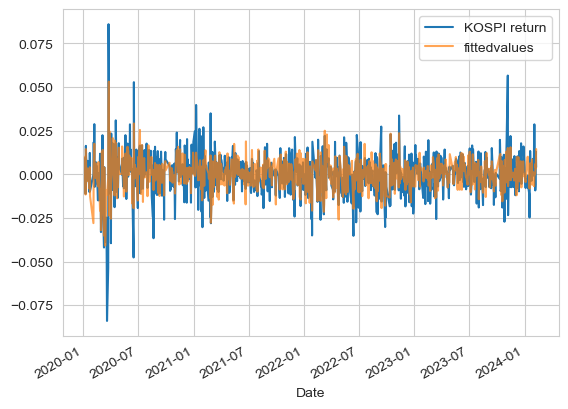

In [27]:
ret_matrix['KOSPI'].plot(label = 'KOSPI return')
fit.fittedvalues.plot(alpha = 0.7, label = 'fittedvalues')
plt.legend()
plt.show()

In [28]:
fit.params # coefficient

const    -0.000023
S&P500    0.070947
SSEC      0.279445
NIKKEI    0.502861
dtype: float64

#### Seaborn

- `matplotlib`과 비슷한 기능을 하지만, 좀 더 advanced한 레벨의 시각화를 보여준다
- 다만, 사용법이 까다롭기 때문에 유연하게 사용하기 위해서는 익숙해지는 과정이 필요하다

**heatmap**

- 행렬 형태의 데이터를 시각적으로 나타낼 때 사용한다.
- 금융에서는 주로 Covariance, Correlation을 확인하기 위해 사용한다.

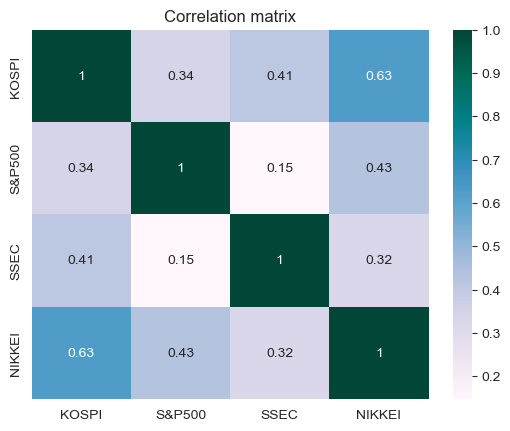

In [29]:
import seaborn as sns

sns.heatmap(
    ret_matrix.corr(),
    annot = True, # 지표 출력
    cmap = 'PuBuGn' # coloar 지정
)
plt.title('Correlation matrix')
plt.show()

**histplot**

- 분포를 확인할 수 있다
- 주로 주식 수익률의 분포가 어떤 모양을 띄고 있는지 확인할 때 사용한다

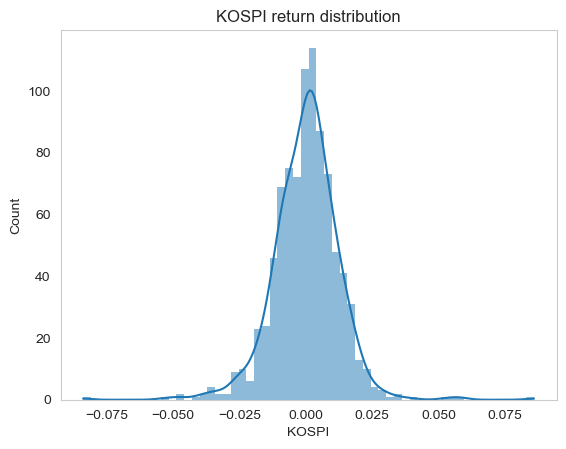

In [32]:
import warnings
warnings.filterwarnings('ignore')
sns.histplot(
    ret_matrix['KOSPI'],
    kde = True, # 분포선을 그려준다
    edgecolor = 'none'
)
plt.grid()
plt.title('KOSPI return distribution')
plt.show()

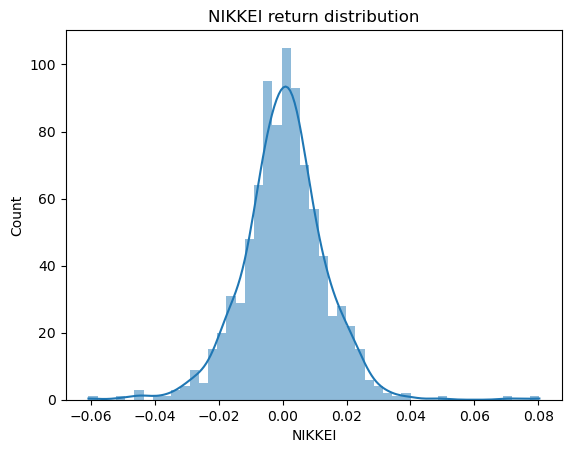

In [70]:
sns.histplot(
    ret_matrix['NIKKEI'],
    kde = True, # 분포선을 그려준다
    edgecolor = 'none'
)
plt.title('NIKKEI return distribution')
plt.show()

두개 이상의 분포를 그리기 위해서는 차례대로 쌓으면 된다

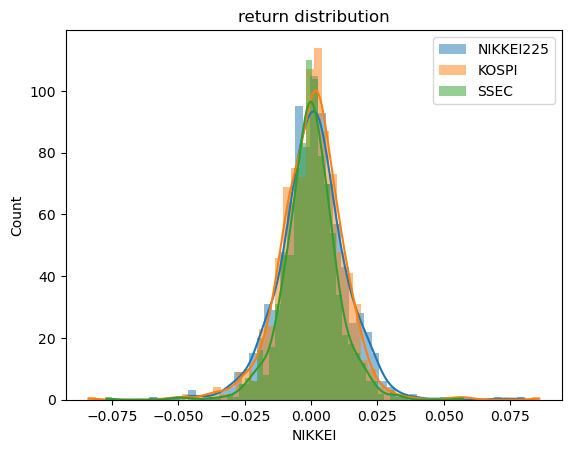

In [76]:
sns.histplot(
    ret_matrix['NIKKEI'],
    kde = True,
    edgecolor = 'none',
    label = 'NIKKEI225'
)
sns.histplot(
    ret_matrix['KOSPI'],
    kde = True, 
    edgecolor = 'none',
    label = 'KOSPI'
)
sns.histplot(
    ret_matrix['SSEC'],
    kde = True, 
    edgecolor = 'none',
    label = 'SSEC'
)
plt.title('return distribution')
plt.legend()
plt.show()

분포선만을 보고 싶을 때에는 `kdeplot()`을 사용한다

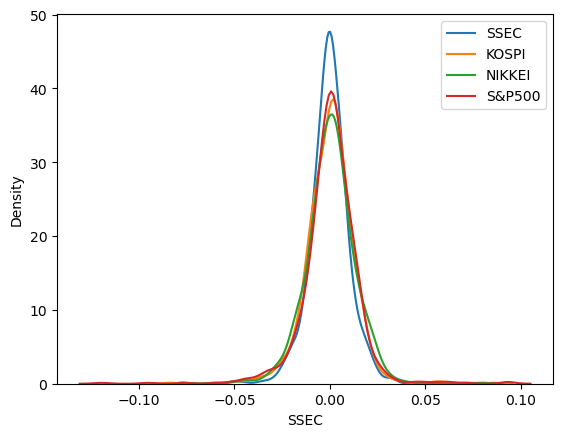

In [80]:
sns.kdeplot(ret_matrix['SSEC'], label = 'SSEC')
sns.kdeplot(ret_matrix['KOSPI'], label = 'KOSPI')
sns.kdeplot(ret_matrix['NIKKEI'], label = 'NIKKEI')
sns.kdeplot(ret_matrix['S&P500'], label = 'S&P500')
plt.legend()
plt.show()

**lineplot**

- 선형 그래프를 그린다
- 기본적으로 matplotlib와 비슷한 기능을 한다

<Axes: xlabel='Date', ylabel='KOSPI'>

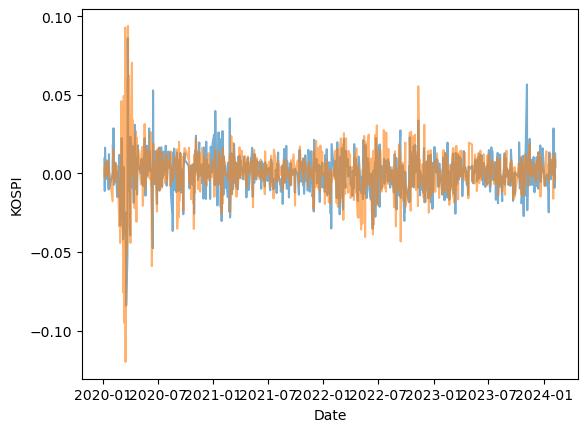

In [85]:
sns.lineplot(ret_matrix['KOSPI'], alpha = 0.6)
sns.lineplot(ret_matrix['S&P500'], alpha = 0.6)

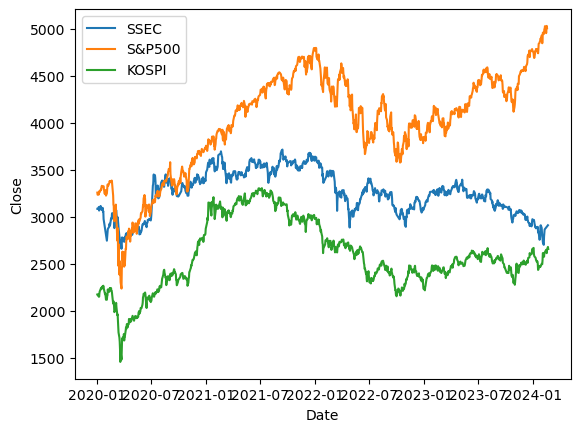

In [93]:
sns.lineplot(ssec.Close, label = 'SSEC')
sns.lineplot(snp.Close, label = 'S&P500')
sns.lineplot(kospi.Close.astype(float), label = 'KOSPI')
plt.legend()
plt.show()

#### Allocation

- 자산배분의 가장 큰 의미는 **특성이 최대한 다른 자산들** 에 분산 투자를 하는 것이다
- 즉, 역사적 데이터가 서로 최대한 다른 자산들을 선정해 배분을 하는 것이다
- 자산 사이의 수리적 거리가 멀 수록 배분의 효과가 보통 크게 나타난다

In [33]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'PYPL', 'ADBE', 'INTC', 'CSCO', 'CMCSA', 
    '^FVX','^TYX','GC=F','SI=F'
]
price = pd.DataFrame()
for i in tickers :
    price = pd.concat([
        price, 
        yf.download(i, start = start_date, end = end_date)['Close']
    ], axis = 1)
price.columns = tickers
price.index = pd.to_datetime(price.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [34]:
price_ret = price.pct_change().dropna()

In [35]:
price_ret

,AAPL,MSFT,GOOGL,AMZN,PYPL,ADBE,INTC,CSCO,CMCSA,^FVX,^TYX,GC=F,SI=F
2020-01-03,-0.009722,-0.012452,-0.005231,-0.012139,-0.017968,-0.007834,-0.012163,-0.016316,-0.007935,-0.050868,-0.039299,0.016202,0.005677
2020-01-06,0.007968,0.002585,0.026654,0.014886,0.012964,0.005726,-0.002829,0.003569,-0.007554,0.015763,0.014228,0.010973,0.001605
2020-01-07,-0.004703,-0.009118,-0.001932,0.002092,-0.004538,-0.000959,-0.016686,-0.006485,0.005821,0.004966,0.010522,0.003576,0.012101
2020-01-08,0.016086,0.015928,0.007118,-0.007809,0.019604,0.013438,0.000679,0.000632,0.010238,0.028413,0.022993,-0.009161,-0.012448
2020-01-09,0.021241,0.012493,0.010498,0.004799,0.006707,0.007636,0.005596,-0.004209,0.002644,-0.006006,-0.011875,-0.003660,-0.012605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,-0.004810,0.007802,0.005512,0.013876,0.010470,0.004602,0.023865,0.012893,0.004062,-0.016906,-0.004030,-0.001305,0.010635
2024-02-15,-0.001575,-0.007155,-0.021721,-0.006901,0.014099,-0.023517,-0.003168,-0.024264,-0.005236,-0.006596,-0.006070,0.005929,0.026018
2024-02-16,-0.008430,-0.006149,-0.015760,-0.001708,-0.009380,-0.074148,-0.012259,-0.012638,-0.013397,0.016837,0.006107,0.004695,0.023001
2023-11-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009943,0.000000


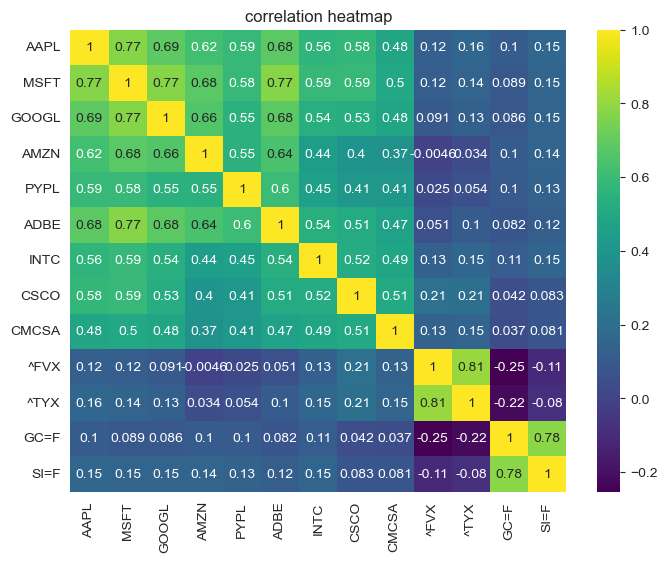

In [36]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(
    price_ret.corr(),
    cmap = 'viridis',
    annot = True,
    ax = ax
)
plt.title('correlation heatmap')
plt.show()

<Axes: >

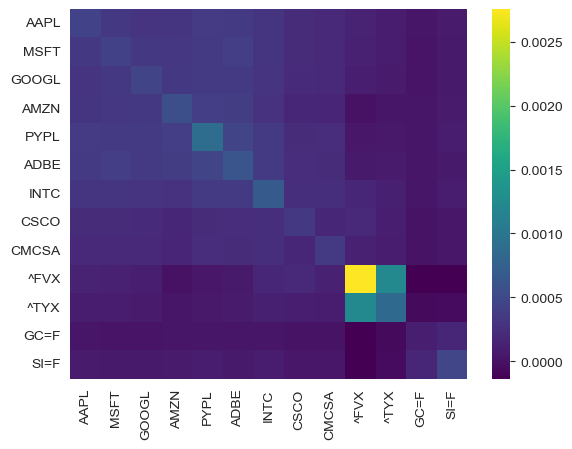

In [37]:
sns.heatmap(
    price_ret.cov(),
    cmap = 'viridis'
)

**clustermap**

- clustermap을 통해 자산간 계층적 관계를 확인할 수 있다.
- 어떤 자산들이 유사한 특성을 가지고 있는지 dendrogram으로 확인 가능하다

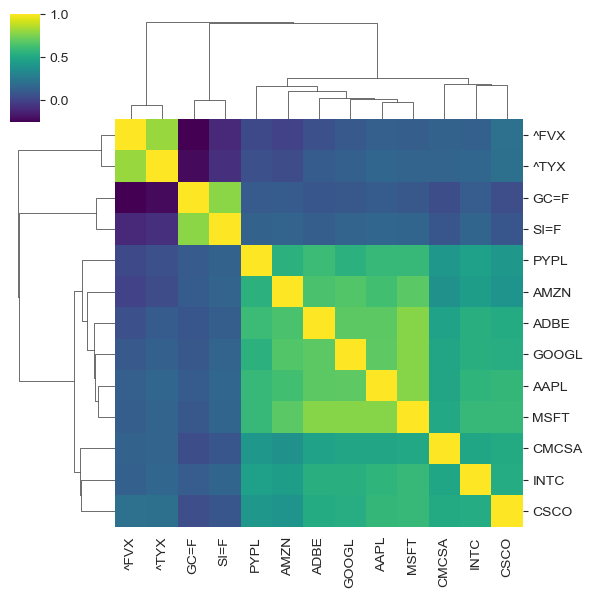

In [38]:
sns.clustermap(
    price_ret.corr(),
    figsize = (6, 6),
    cmap = 'viridis'
)

동일 자산 비중을 가정한 경우

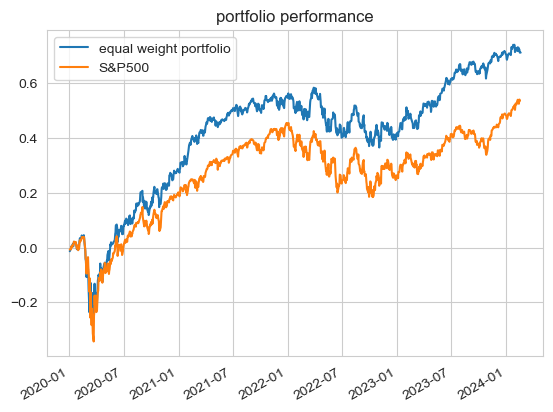

In [39]:
((1 / 13) * price_ret).sum(axis = 1).cumsum().plot(label = 'equal weight portfolio')
plt.plot(snp_ret.cumsum(), label = 'S&P500')
plt.legend()
plt.title('portfolio performance')
plt.show()

원자재 20%, 채권 30%, 위험자산 50%를 가정한 경우

In [40]:
price_ret

,AAPL,MSFT,GOOGL,AMZN,PYPL,ADBE,INTC,CSCO,CMCSA,^FVX,^TYX,GC=F,SI=F
2020-01-03,-0.009722,-0.012452,-0.005231,-0.012139,-0.017968,-0.007834,-0.012163,-0.016316,-0.007935,-0.050868,-0.039299,0.016202,0.005677
2020-01-06,0.007968,0.002585,0.026654,0.014886,0.012964,0.005726,-0.002829,0.003569,-0.007554,0.015763,0.014228,0.010973,0.001605
2020-01-07,-0.004703,-0.009118,-0.001932,0.002092,-0.004538,-0.000959,-0.016686,-0.006485,0.005821,0.004966,0.010522,0.003576,0.012101
2020-01-08,0.016086,0.015928,0.007118,-0.007809,0.019604,0.013438,0.000679,0.000632,0.010238,0.028413,0.022993,-0.009161,-0.012448
2020-01-09,0.021241,0.012493,0.010498,0.004799,0.006707,0.007636,0.005596,-0.004209,0.002644,-0.006006,-0.011875,-0.003660,-0.012605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,-0.004810,0.007802,0.005512,0.013876,0.010470,0.004602,0.023865,0.012893,0.004062,-0.016906,-0.004030,-0.001305,0.010635
2024-02-15,-0.001575,-0.007155,-0.021721,-0.006901,0.014099,-0.023517,-0.003168,-0.024264,-0.005236,-0.006596,-0.006070,0.005929,0.026018
2024-02-16,-0.008430,-0.006149,-0.015760,-0.001708,-0.009380,-0.074148,-0.012259,-0.012638,-0.013397,0.016837,0.006107,0.004695,0.023001
2023-11-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009943,0.000000


In [41]:
bond = (0.3 * 0.5 * price_ret[['^FVX','^TYX']]).sum(axis = 1).cumsum() # 채권
commodity = (0.2 * 0.5 * price_ret[['GC=F','SI=F']]).sum(axis = 1).cumsum() # 원자재
stock = (0.5 * (1 / 9) * price_ret.iloc[:,:9]).sum(axis = 1).cumsum() # 위험자산

In [42]:
portfolio = bond + commodity + stock

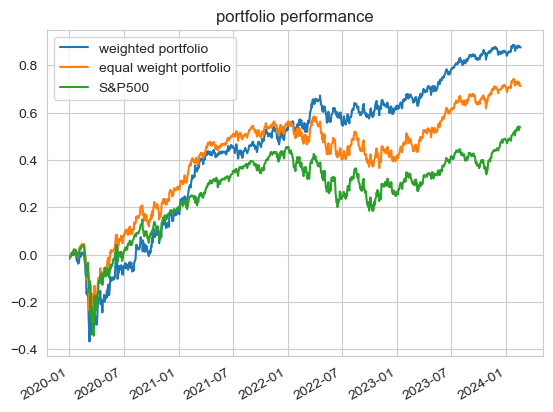

In [43]:
portfolio.plot(label = 'weighted portfolio')
((1 / 13) * price_ret).sum(axis = 1).cumsum().plot(label = 'equal weight portfolio')
plt.plot(snp_ret.cumsum(), label = 'S&P500')
plt.legend()
plt.title('portfolio performance')
plt.show()